In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import re
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import matplotlib.font_manager

fonts = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
print(fonts)

['/usr/share/fonts/truetype/noto/NotoSerifTelugu-Regular.ttf', '/usr/share/texmf/fonts/opentype/public/lm/lmromanslant9-regular.otf', '/usr/share/fonts/truetype/noto/NotoSerifKhojki-Regular.ttf', '/usr/share/fonts/truetype/unfonts-extra/UnPilgia.ttf', '/usr/share/fonts/truetype/noto/NotoSansSharada-Regular.ttf', '/usr/share/fonts/truetype/noto/NotoSansDevanagari-Bold.ttf', '/usr/share/fonts/truetype/ubuntu/Ubuntu-BI.ttf', '/usr/share/texmf/fonts/opentype/public/lm/lmroman8-regular.otf', '/usr/share/fonts/truetype/gentiumplus/GentiumPlus-Bold.ttf', '/usr/share/fonts/truetype/noto/NotoSansMono-Bold.ttf', '/usr/share/fonts/opentype/linux-libertine/LinBiolinum_RB.otf', '/usr/share/fonts/truetype/unfonts-core/UnPilgi.ttf', '/usr/share/texmf/fonts/opentype/public/lm/lmromanunsl10-regular.otf', '/usr/share/texmf/fonts/opentype/public/lm/lmmonocaps10-regular.otf', '/usr/share/fonts/opentype/freefont/FreeSansBold.otf', '/usr/share/fonts/opentype/urw-base35/C059-BdIta.otf', '/usr/share/fonts/ope

In [2]:
path = 'Rust_coords'
def import_coords(file):
    file_path = path + "/" + file 
    coords = pd.read_csv(file_path, skiprows=4, sep='\t', header=None)
    coords.columns = ["S1", "E1", "S2", "E2", "LENR", "LENQ", "Identity", "LEN1", "LEN2", "COVR", "COVQ", "REF", "QUERY"]
    coords["strand"] = np.where(coords["S2"] < coords["E2"], "+", "-")
    return coords

In [3]:
def filter_nucmer(df, mini_length, mini_identity):
    df = df[(df.LENR > mini_length)]
    df = df[(df.LENQ > mini_length)]
    df = df[(df.Identity >= mini_identity)]
    return df

In [58]:
coords = import_coords("MAT_chr.coords")
filtered_coords=filter_nucmer(coords, 1000, 90)

In [31]:
gff_path = path + "/MAT.gff"
gff = pd.read_csv(gff_path, sep='\t', header=None)
gff.columns = ["seqid", "source", "type", "start", "end", "score1", "strand", "score2", "geneid"]
MAT_list = pd.read_table(path + "/MAT.list", sep=' ', header=None)
#Join MAT_list with gff to get the gene name
MAT_list.columns = ["geneid", "MAT"]
gff = MAT_list.merge(gff, on="geneid")

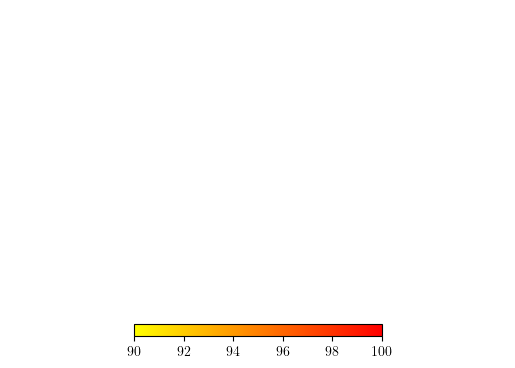

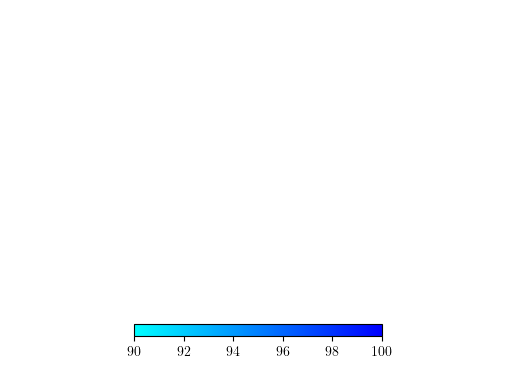

In [70]:
# Forward Strand
fig, ax = plt.subplots()
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', shrink=0.5)
#cbar.set_label('Identity (+)', size = 20)
ax.axis('off')
plt.show()

# Reverse Strand
fig, ax = plt.subplots()
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap2)
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', shrink=0.5)
#cbar.set_label('Identity (-)', size = 20)
ax.axis('off')
plt.show()

In [25]:
#If has only 1 query and 1 ref, use this one
def makeplot(paf, fsize):
    rows=len(paf["QUERY"].unique())
    cols=len(paf["REF"].unique())
    plt.figure(figsize=(fsize*cols,fsize*rows))
    plt.rcParams['text.usetex'] = True
    x_chromosome = paf["QUERY"].unique()
    y_chromosome = paf["REF"].unique()
    gff_query = gff[gff["seqid"] == x_chromosome[0]]
    gff_ref = gff[gff["seqid"] == y_chromosome[0]]
    #Reverse y_chromosome order
    #y_chromosome = y_chromosome[::-1]
    for row in range(rows):
       for col in range(cols):
            filter_paf = paf[(paf.QUERY.isin([x_chromosome[row]])) & (paf.REF.isin([y_chromosome[col]]))]
            filename = str(filter_paf["QUERY"].unique()[0]) + "_" + str(filter_paf["REF"].unique()[0]) + ".svg"
 ##           if len(filter_paf) > 0 :
            for index, line in filter_paf.iterrows():        
                if line['strand'] == '+':
                   #     ax[col,row].set(xlabel=filter_paf["QUERY"].unique())
                        point1 = [line['S1'], line['S2']]
                        point2 = [line['E1'], line['E2']]
                        x_tmp = [point1[1], point2[1]]
                        y_tmp = [point1[0], point2[0]]
                        identity = [line['Identity']]
                        plt.plot(x_tmp, y_tmp, linewidth=1.5, color=cmap(norm(identity)))                      
                if line['strand'] == '-':
                  #      ax[col,row].set(xlabel=filter_paf["QUERY"].unique())
                        point1 = [line['S1'], line['S2']]
                        point2 = [line['E1'], line['E2']]
                        x_tmp = [point1[1], point2[1]]
                        y_tmp = [point1[0], point2[0]]
                        identity = [line['Identity']]
                        plt.plot(x_tmp, y_tmp, linewidth=1.5, color=cmap2(norm(identity)))
                if row == 0:
                  unique_str = filter_paf["REF"].unique()[0]
                  parts = unique_str.split("_")
                  labely = parts[0]
                  labely_c = parts[1]
                  plt.ylabel(r'\textit{' + labely + '}' + " "+ labely_c, fontsize=15,fontname='Times New Roman')
                if col == 0:
                  unique_str = filter_paf["QUERY"].unique()[0]
                  parts = unique_str.split("_")
                  labelx = parts[0]
                  labelx_c = parts[1]
                  plt.xlabel(r'\textit{' + labelx + '}' + labelx_c, fontsize=15,fontname='Times New Roman')
                #add labels and lines for MAT
    for val in (gff_query.start+gff_query.end)/2:
        plt.axvline(x=val, color='k', linewidth=1)
   # for MAT in gff_query.MAT.unique():
   #     plt.text(val, 700000, MAT, fontsize=10, color='k', horizontalalignment='center', verticalalignment='bottom', fontstyle='italic')
    for val in (gff_ref.start+gff_ref.end)/2:
        plt.axhline(y=val, color='k', linewidth=1)
   # for MAT in gff_ref.MAT.unique():
   #     plt.text(700000, val, MAT, fontsize=10, color='k', horizontalalignment='left', verticalalignment='top', fontstyle='italic')
    plt.xticks(np.arange(0, 10000000, 1000000))
    plt.xticks(fontsize=10)
    plt.yticks(np.arange(0, 10000000, 1000000))
    plt.yticks(fontsize=10)
                #Set maximum axis limit based on chromosome LEN1 and LEN2
    plt.xlim(0, filter_paf["LEN2"].unique())
    plt.ylim(0, filter_paf["LEN1"].unique())
#    plt.savefig(filename, dpi=300, format='png')
    #if has subplot
    #Put both of the colorbar on the right
 #   plt.subplots_adjust(right=1)
    #Create colorbar
 #   sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    #Empty array for the data range
 #   sm._A = []
    #Add the colorbar to the figure
 #   cbar = plt.colorbar(sm)
    #set size of the subplot
 #   cbar.set_label('Identity')
plt.show()

In [52]:
#If has only 1 query and 1 ref, use this one
def make_zoomin_plot(paf, fsize, zoomin):
    rows=len(paf["QUERY"].unique())
    cols=len(paf["REF"].unique())
    plt.figure(figsize=(fsize*cols,fsize*rows))
    x_chromosome = paf["QUERY"].unique()
    y_chromosome = paf["REF"].unique()
    gff_query = gff[gff["seqid"] == x_chromosome[0]]
    gff_ref = gff[gff["seqid"] == y_chromosome[0]]
    filter_s_query = gff_query.start.min() - zoomin
    filter_e_query = gff_query.end.max() + zoomin
    filter_s_ref = gff_ref.start.min() - zoomin
    filter_e_ref = gff_ref.end.max() + zoomin
    #Reverse y_chromosome order
    #y_chromosome = y_chromosome[::-1]
    for row in range(rows):
       for col in range(cols):
            filter_paf = paf[(paf.QUERY.isin([x_chromosome[row]])) & (paf.REF.isin([y_chromosome[col]]))]
            filename = str(filter_paf["QUERY"].unique()[0]) + "_" + str(filter_paf["REF"].unique()[0]) + "_zoomin.svg"
 ##           if len(filter_paf) > 0 :
            for index, line in filter_paf.iterrows():        
                if line['strand'] == '+':
                   #     ax[col,row].set(xlabel=filter_paf["QUERY"].unique())
                        point1 = [line['S1'], line['S2']]
                        point2 = [line['E1'], line['E2']]
                        x_tmp = [point1[1], point2[1]]
                        y_tmp = [point1[0], point2[0]]
                        identity = [line['Identity']]
                        plt.plot(x_tmp, y_tmp, linewidth=1, color=cmap(norm(identity)))                      
                if line['strand'] == '-':
                  #      ax[col,row].set(xlabel=filter_paf["QUERY"].unique())
                        point1 = [line['S1'], line['S2']]
                        point2 = [line['E1'], line['E2']]
                        x_tmp = [point1[1], point2[1]]
                        y_tmp = [point1[0], point2[0]]
                        identity = [line['Identity']]
                        plt.plot(x_tmp, y_tmp, linewidth=1, color=cmap2(norm(identity)))
                if row == 0:
                  unique_str = filter_paf["REF"].unique()[0]
                  parts = unique_str.split("_")
                  labely = parts[0]
                  labely_c = parts[1] 
                  plt.ylabel(r'\textit{' + labely + '}' + labely_c, fontsize=15, fontname='Times New Roman')
                if col == max(range(cols)):
                  unique_str = filter_paf["QUERY"].unique()[0]
                  parts = unique_str.split("_")
                  labelx = parts[0]
                  labelx_c = parts[1] 
                  plt.xlabel(r'\textit{' + labelx + '}' + labelx_c, fontsize=15, fontname='Times New Roman')
                MAT = gff_query.MAT.unique()
                if "STE3.2-3" not in MAT and "STE3.2-2" not in MAT:
                  for M in MAT:
                     M1 = gff_query[gff_query.MAT == M]
                     M2 = gff_ref[gff_ref.MAT == M]
                     # Add rectangle
                     rectangle = Rectangle((M1.start.min(), M2.start.min()), (M1.end - M1.start).min(), (M2.end -M2.start).min(), linewidth=0, edgecolor='r', facecolor=(1.0, 0.8, 0.8, 0.5))
                     plt.gca().add_patch(rectangle)
                else:
                      M1 = gff_query[gff_query.MAT == "STE3.2-3"]
                      M2 = gff_ref[gff_ref.MAT == "STE3.2-2"]
                      # Add rectangle
                      rectangle = Rectangle((M1.start.min(), M2.start.min()), (M1.end - M1.start).min(), (M2.end -M2.start).min(), linewidth=0, edgecolor='r', facecolor=(1.0, 0.8, 0.8, 0.5))
                      plt.gca().add_patch(rectangle)
                plt.xlim(filter_s_query, filter_e_query)
                plt.ylim(filter_s_ref, filter_e_ref)
                plt.xticks(fontsize=10)
                plt.yticks(fontsize=10)
           
#            plt.savefig(filename, dpi=300, format='png') 
plt.show()

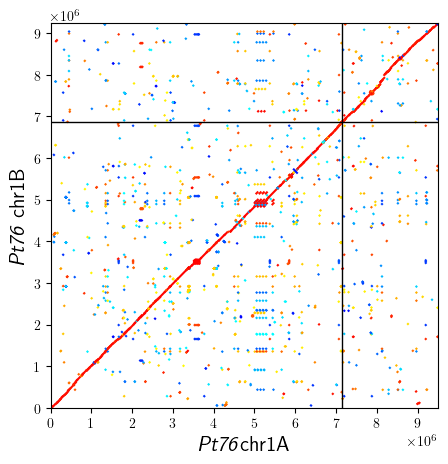

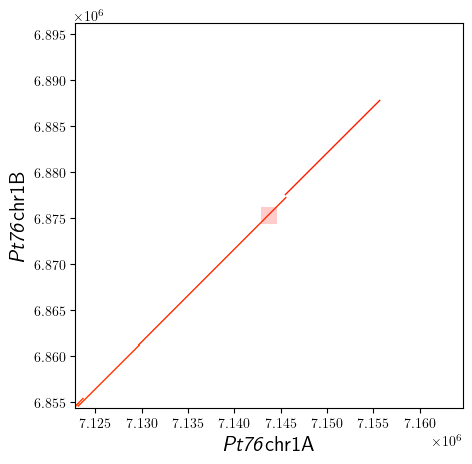

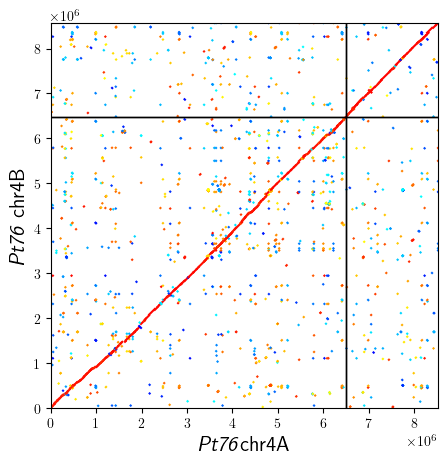

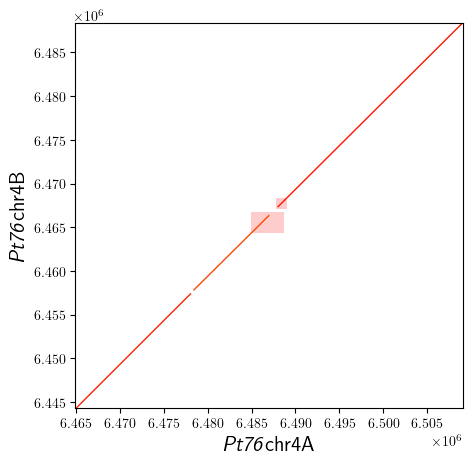

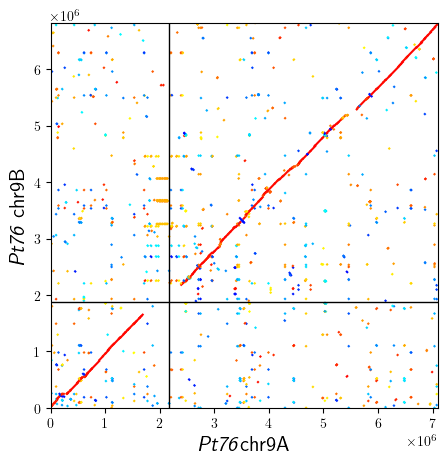

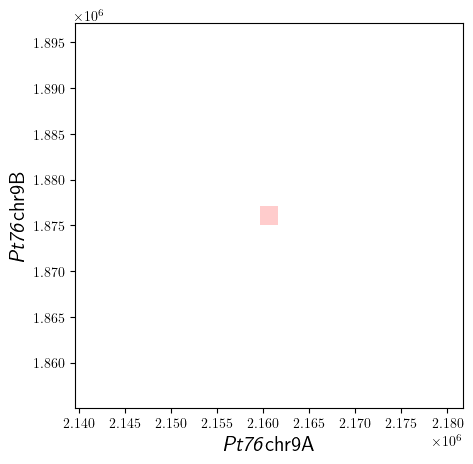

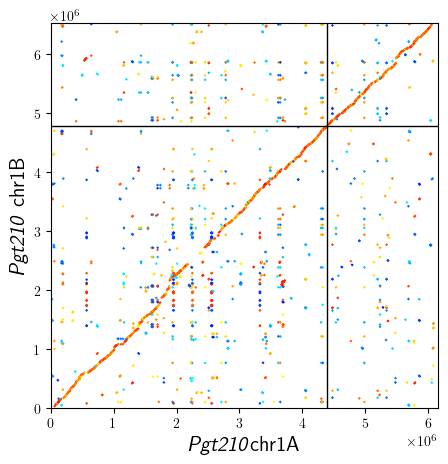

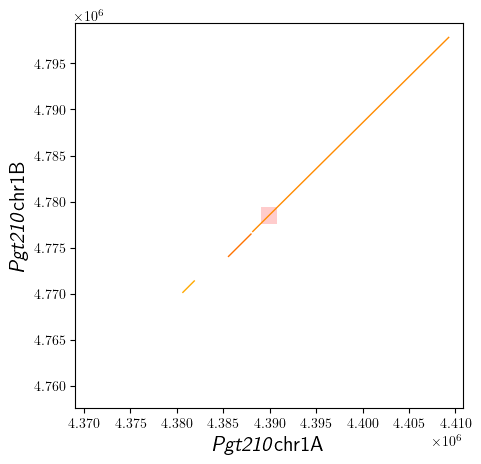

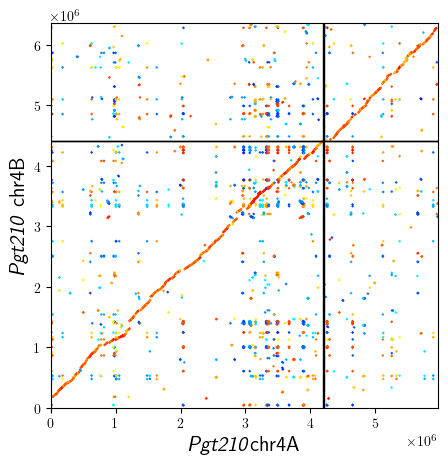

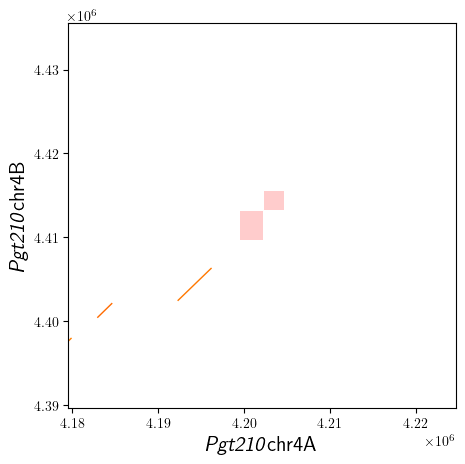

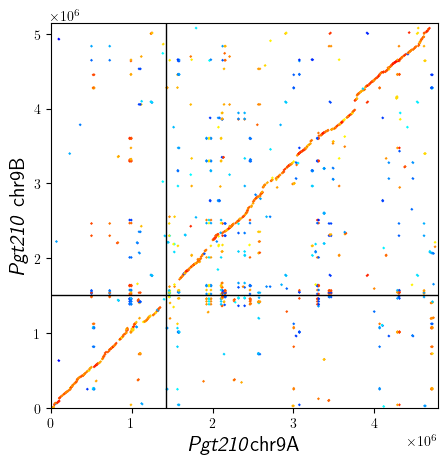

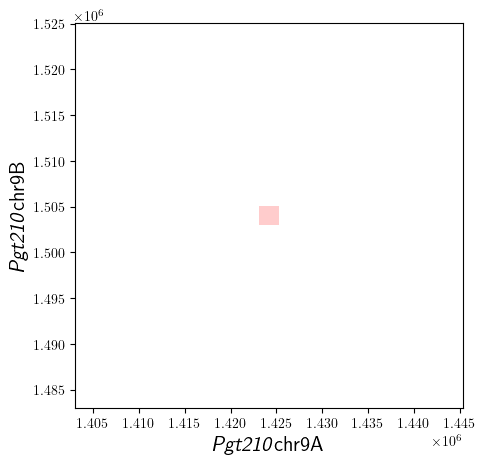

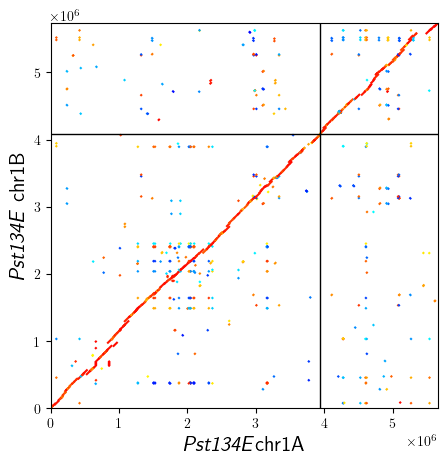

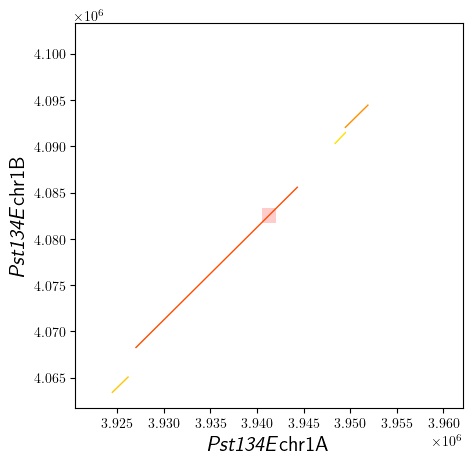

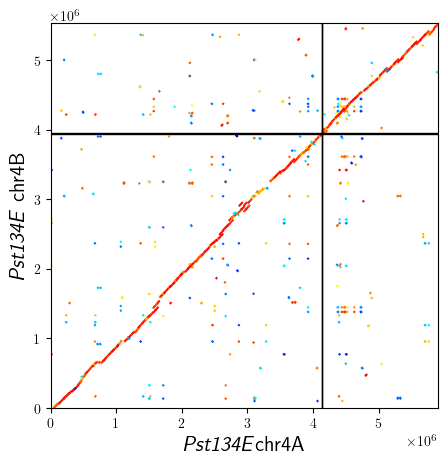

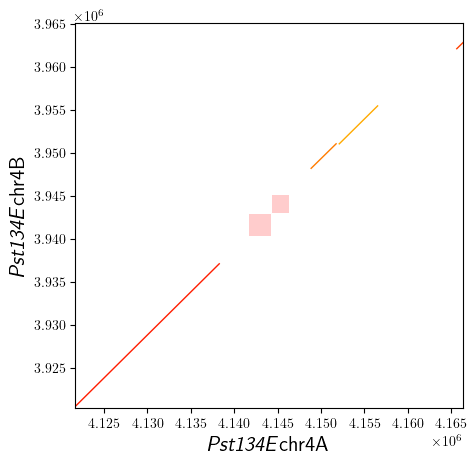

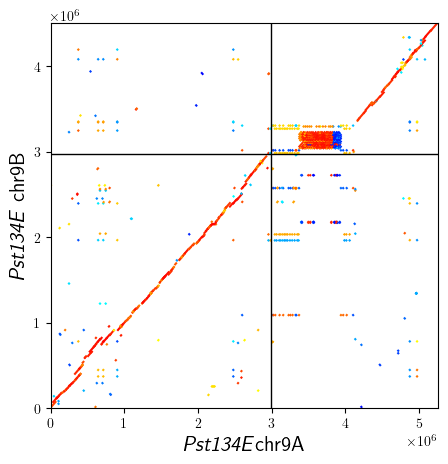

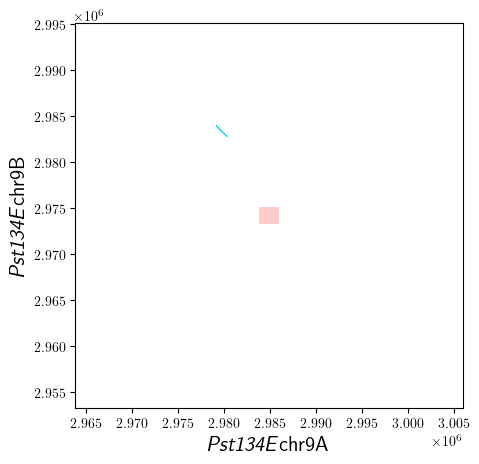

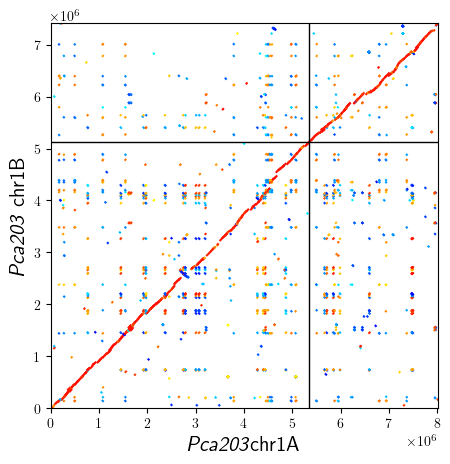

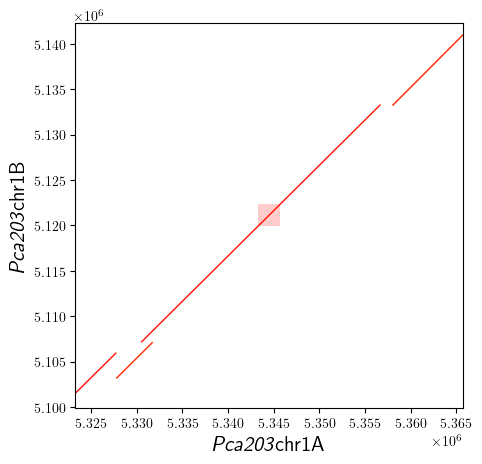

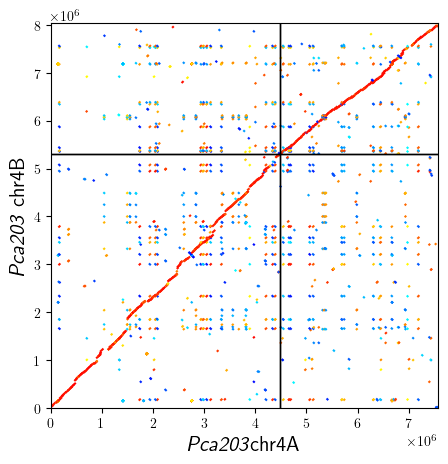

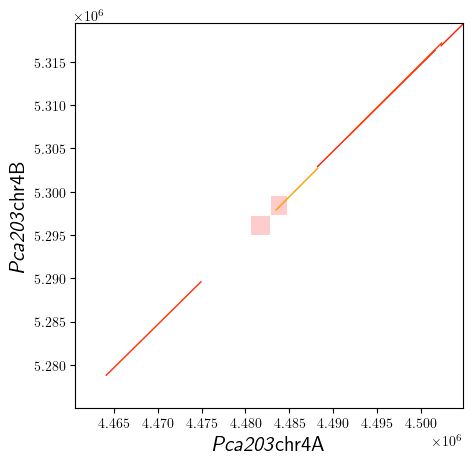

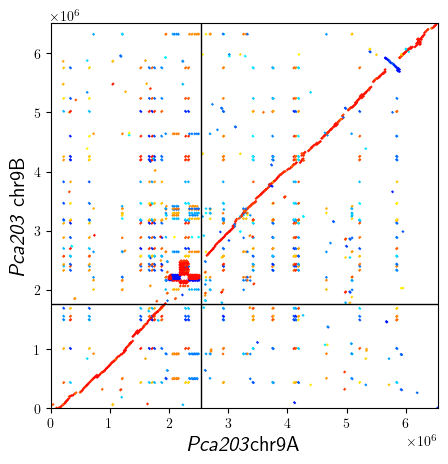

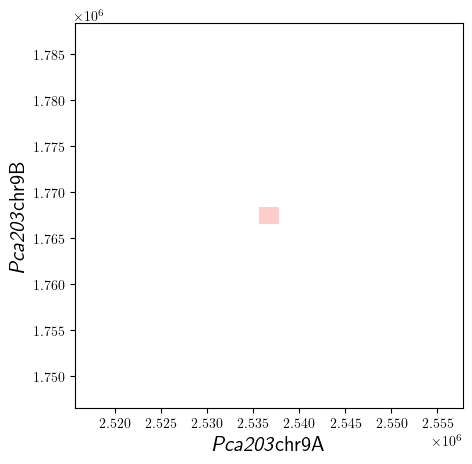

In [65]:
Species = ["Pt76","Pgt210", "Pst134E"]
chromosome = ["chr1", "chr4", "chr9"]
for s in Species:
    for c in chromosome:
        df=filtered_coords[(filtered_coords.QUERY.str.contains(s)) & (filtered_coords.REF.str.contains(s))&
                       (filtered_coords.QUERY.str.contains(c + "A")) & (filtered_coords.REF.str.contains(c + "B"))]
        makeplot(df, 5)
        make_zoomin_plot(df, 5, 20000)
        plt.show()
#Use 2000 bp as the minimum length for Pca to remove noise
for c in chromosome:
        df=filter_nucmer(coords, 2000, 90)
        df=df[(df.QUERY.str.contains("Pca203")) & (df.REF.str.contains("Pca203"))&
                       (df.QUERY.str.contains(c + "A")) & (df.REF.str.contains(c + "B"))]
        makeplot(df, 5)
        make_zoomin_plot(df, 5, 20000)
        plt.show()
